In [12]:
import numpy as np
import matplotlib.pyplot as plt

### b) Quantization and quantization noise
In this exercise you will develop quantization routines that you will use
when developing audio coders in later exercises.

<b> 1. Write functions that quantize floating point numbers from -1.0 up to
1.0 using R-bit midtread uniform quantization; R-bit midrise uniform
quantization; and Rs scale factor bits, Rm mantissa bits midtread
floating point quantization. </b>

In [24]:
def midrise_uniform_quantization(number, R):
    if number >= 0:
        s = 0
    else:
        s = 1
    if np.abs(number) >= 1:
        code = 2 ** (R-1) - 1
    else:
        code = int(2 ** (R-1) * np.abs(number))
    coded = bin(code).split('b')[1]
    n_zeros = R - 1 - len(coded)
    return str(s) + '0' * n_zeros + coded

def midrise_uniform_dequantization(code, R):
    if code[0] == '0':
        sign = 1
    else:
        sign = -1
    return sign * (int(code[1:], 2) + 0.5) / 2 ** (R-1)

def midtread_uniform_quantization(number, R):
    if number >= 0:
        s = 0
    else:
        s = 1
    if np.abs(number) >= 1:
        code = 2 ** (R-1) - 1
    else:
        code = int(((2 ** R - 1) * np.abs(number) + 1) / 2)
    coded = bin(code).split('b')[1]
    n_zeros = R - 1 - len(coded)
    return str(s) + '0' * n_zeros + coded 


def midtread_uniform_dequantization(code, R):
    if code[0] == '0':
        sign = 1
    else:
        sign = -1
    return sign * 2 * int(code[1:], 2) / (2 ** R -1)

def floating_point_quantization_old(number, Rm, Rs, method='midtread'):
    if method == 'midtread':
        code = midtread_uniform_quantization(number, 2 ** Rs - 1 + Rm)
    else:
        code = midrise_uniform_quantization(number, 2 ** Rs - 1 + Rm)
    lz = len(code[1:].split('1')[0])
    if (2 ** Rs - 1) > lz:
        scale = bin((2 ** Rs - 1 - lz)).split('b')[1]
    else:
        scale = bin(0).split('b')[1]
        
    if scale == '0':
        mantissa = BitArray(bin=code[0] + '0' * (Rm - 1 - (lz + 1)) + code[lz + 1 : (lz + 1) + Rm - 1])
    else:
        mantissa = BitArray(bin=code[0] + '0' * (Rm - 1 - (lz + 2)) + code[lz + 2 : (lz + 2) + Rm - 1])
    scale_lz = Rs - len(scale)
    return '0' * scale_lz + scale, mantissa.bin

def floating_point_quantization(number, Rs, Rm, method='midtread'):
    if method == 'midtread':
        code = midtread_uniform_quantization(number, 2 ** Rs - 1 + Rm)
    else:
        code = midrise_uniform_quantization(number, 2 ** Rs - 1 + Rm)
        print('code: ', code)
    lz = len(code[1:].split('1')[0])
    if (2 ** Rs - 1) > lz:
        scale_hat = bin((2 ** Rs - 1 - lz)).split('b')[1]
        scale = '0' * (Rs - len(scale_hat)) + scale_hat
    else:
        scale = '0' * Rs
    #print('scale: ', scale)
    if int(code, 2) == 0:
        mantissa = '0' * Rm
    elif int(scale, 2) == 0:
        mantissa = code[0]
        mantissa += code[2 ** Rs: 2 ** Rs + (Rm -1)]
    else:
        mantissa = code[0]
        mantissa += code[lz + 2: (lz + 2) + (Rm -1)]
    return scale, mantissa

def floating_point_dequantization(scale, mantissa, Rs, Rm, method='midtread'):
    R = 2 ** Rs - 1 + Rm
    code = mantissa[0]
    code += '0' * (2 ** Rs - 1 - int(scale, 2))
    if int(scale, 2) == 0:
        code += mantissa[1:] 
    elif int(scale, 2) == 1:
        code += '1' + mantissa[1:] 
    else:
        code += '1' + mantissa[1:] + '1'
        code += '0' * max(R - len(code), 0)
    if method == 'midtread':
        return midtread_uniform_dequantization(code, R)
    else: 
        return midrise_uniform_dequantization(code, R)

<b> 2. Create a version of Figure 10 using 1.1 kHz sine waves sampled at 8
kHz as input. </b>

In [78]:
def SNR(x_in, q):
    return 10 * np.log10(np.mean(x_in ** 2)/(np.mean(q ** 2) + np.finfo(float).eps))

In [79]:
Fs = 8000
n = np.linspace(-1, 1, 8000)

In [80]:
step = 0.01
amplitudes = np.logspace(-5, 0.2, (1 / step))

In [81]:
X_in = np.zeros((len(amplitudes), len(n)))

In [82]:
for i in range(len(amplitudes)):
    x = amplitudes[i] * np.sin(2 * np.pi * 1100 * n)
    X_in[i, :] = x

In [83]:
SNR_MT6 = []
for i in range(len(amplitudes)):
    x_mt6 = np.array([midtread_uniform_quantization(X_in[i,j], 6) for j in range(len(n))])
    x_out_mt6 = np.array([midtread_uniform_dequantization(x, 6) for x in x_mt6])
    q = X_in[i, :] - x_out_mt6
    SNR_MT6.append(SNR(X_in[i, :], q))

In [84]:
SNR_MT8 = []
for i in range(len(amplitudes)):
    x_mt8 = np.array([midtread_uniform_quantization(X_in[i,j], 8) for j in range(len(n))])
    x_out_mt8 = np.array([midtread_uniform_dequantization(x, 8) for x in x_mt8])
    q = X_in[i, :] - x_out_mt8
    SNR_MT8.append(SNR(X_in[i, :], q))

In [85]:
SNR_MT12 = []
for i in range(len(amplitudes)):
    x_mt12 = np.array([midtread_uniform_quantization(X_in[i,j], 12) for j in range(len(n))])
    x_out_mt12 = np.array([midtread_uniform_dequantization(x, 12) for x in x_mt12])
    q = X_in[i, :] - x_out_mt12
    SNR_MT12.append(SNR(X_in[i, :], q))

In [86]:
SNR_FP = []
for i in range(len(amplitudes)):
    x_fp = np.array([floating_point_quantization(X_in[i,j], 3, 5) for j in range(len(n))])
    x_out_fp = np.array([floating_point_dequantization(s, m, 3, 5) for s, m in x_fp])
    q = X_in[i, :] - x_out_fp
    SNR_FP.append(SNR(X_in[i, :], q))

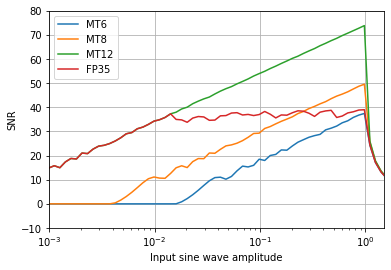

In [87]:
plt.plot(amplitudes, SNR_MT6, label='MT6')
plt.plot(amplitudes, SNR_MT8, label='MT8')
plt.plot(amplitudes, SNR_MT12, label='MT12')
plt.plot(amplitudes, SNR_FP, label='FP35')
plt.xscale('log')
plt.axis([0.001, 1.5, -10, 80])
plt.xlabel("Input sine wave amplitude")
plt.ylabel("SNR")
plt.grid(True)
plt.legend()